In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
from warnings import filterwarnings
filterwarnings("ignore")

def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

In [37]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

In [38]:
def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [39]:
t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])
t = prepare_data(t)

In [40]:
t = create_diffs(t)

In [41]:
t[target] = t[target].shift(1)
t = t.dropna()

In [48]:
codes = t.SecuritiesCode.unique()
new_codes = dict(zip(codes, np.arange(2000)))
t = t.replace({'SecuritiesCode' : new_codes})

In [49]:
secs = t.loc[t['Date'] == '2017-01-04',['SecuritiesCode']].values.squeeze(1)[:1024]
df1 = t.loc[t['Date'] >= '2017-01-04'].reset_index()
df1 = df1.loc[df1.SecuritiesCode.isin(secs)].copy()
dates = df1.Date.unique()

In [68]:
features = ['diffClose', 'ExpectedDividend',]# 'diffOpen', 'diffHigh', 'diffLow', 
            #'diffVolume', 'pctDailyChange',] 
target = 'Target'

In [69]:
X_test, y_test = [], []
X_train, y_train = [], []
history_size = 1 # training history
val_size = 100

for i in range(0, len(dates) - history_size - val_size):
    tmp = []
    for j in range(history_size):
        tmp.append(df1.loc[df1.Date == dates[i+j], [*features]].values.reshape(-1))
    X_train.append(*tmp)
    y_train.append(df1[(df1.SecuritiesCode == 4) & (df1.Date == dates[i + history_size - 1])]
                   [target].values[0])

for i in range(len(dates) - history_size - val_size, len(dates) - history_size):
    tmp = []
    for j in range(history_size):
        tmp.append(df1.loc[df1.Date == dates[i+j], [*features]].values.reshape(-1))
    X_test.append(*tmp)
    y_test.append(df1[(df1.SecuritiesCode == 4) & (df1.Date == dates[i + history_size - 1])]
                   [target].values[0])

In [70]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [71]:
batchSize=256
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
val_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [72]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        nLayers = 5 
        k = 1024
        self.convs = ModuleList([Conv1d(in_channels=k, out_channels=k, kernel_size=4,
                                        stride=4) for i in range(nLayers)])
        self.conv1 = Conv1d(in_channels=1, out_channels=k, kernel_size=len(features),
                            stride=len(features))
        self.layer_o = Linear(k, 1)
        self.activation = LeakyReLU()
        self.dropout = Dropout(p=0.15)

    def forward(self, X):
        X = X.unsqueeze(1)
        convd = self.conv1(X)
        convd = self.activation(convd) + convd
        for conv in self.convs:
            convd = conv(convd)
            convd = self.activation(convd) + convd
            convd = self.dropout(convd)
            
        convd = convd.reshape(X.size(0), -1)
        convd = self.layer_o(convd)
        return convd

In [73]:
model = ConvNet().to(device)

In [74]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-8, factor=0.5)

In [81]:
start_time = datetime.now()

for epoch in range(101):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model.eval()
    
    if epoch % 10 == 0:    
        with torch.no_grad():
            eval_loss = 0
            for i, (inputs, targets) in enumerate(val_dl):
                inputs, targets = inputs.to(device), targets.to(device)
                yhat = model(inputs)
                loss = criterion(yhat, targets)
                eval_loss += loss

        scheduler.step(eval_loss)
        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(val_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0782, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0260, device='cuda:0')
Epoch: 10, train loss: tensor(0.0857, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0261, device='cuda:0')
Epoch: 20, train loss: tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0256, device='cuda:0')
Epoch: 30, train loss: tensor(0.0785, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0256, device='cuda:0')
Epoch: 40, train loss: tensor(0.0829, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0259, device='cuda:0')
Epoch: 50, train loss: tensor(0.0765, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0260, device='cuda:0')
Epoch: 60, train loss: tensor(0.0856, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0265, device='cuda:0')
Epoch: 70, train loss: tensor(0.0751, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0266, device='cuda:0')
Epoch: 80, train 

In [82]:
model.eval()
with torch.no_grad():
    eval_loss = 0
    y_pred = []
    for i, (inputs, targets) in enumerate(test_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        yhat = model(inputs)
        y_pred.append(yhat.item())
        loss = criterion(yhat, targets)
        eval_loss += loss


In [83]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

1.220703125e-07


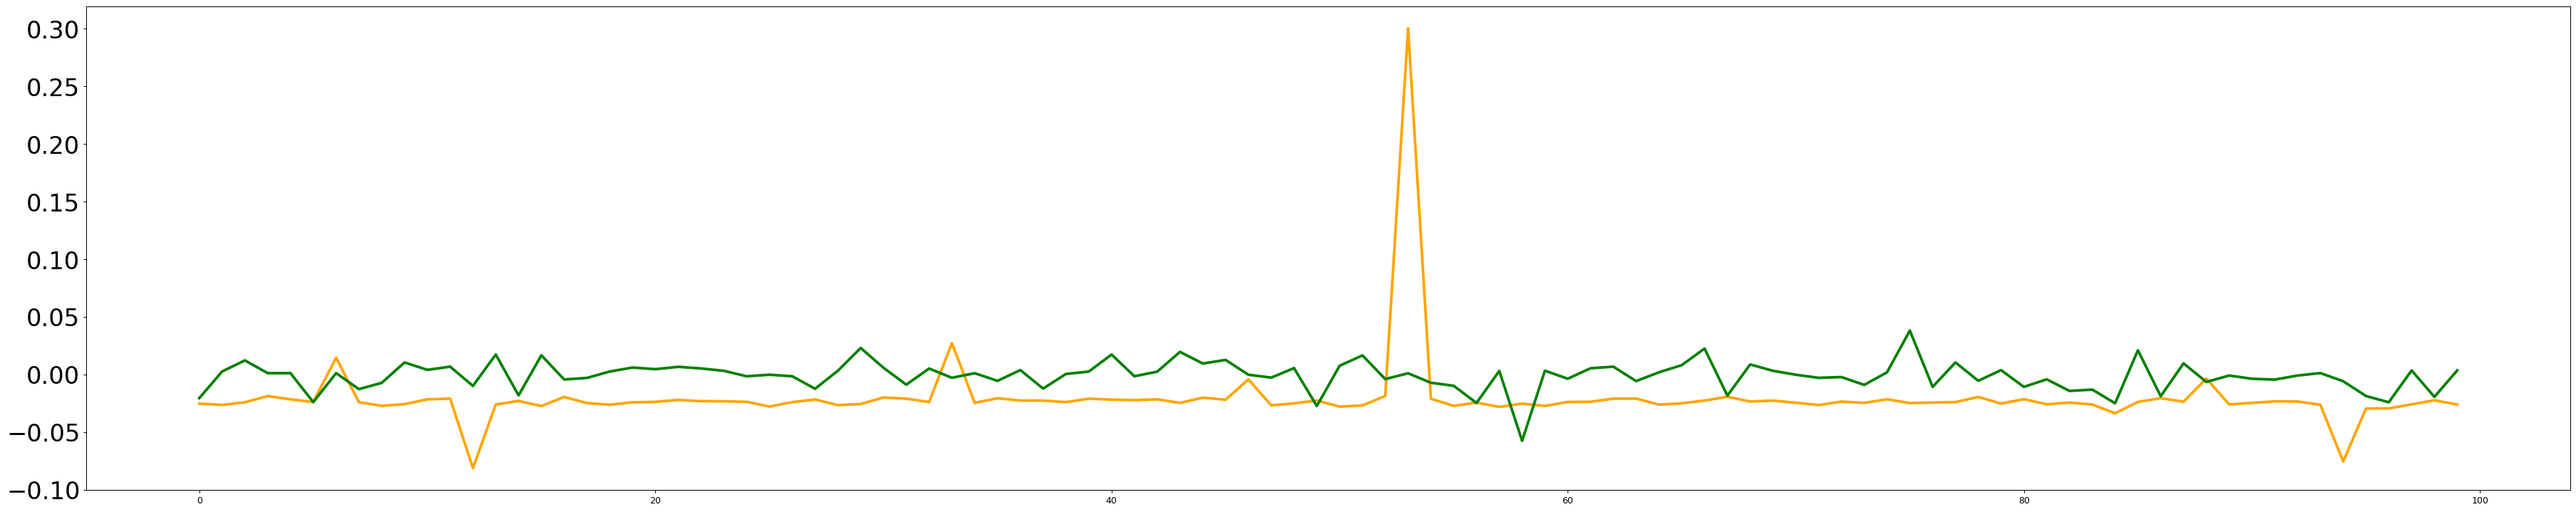

In [84]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.tick_params(axis='y', which='both',    
                labeltop='on', labelbottom='off', labelsize=27)
ax1.plot(y_pred, lw=3, color='orange')
ax1.plot(y_test, lw=3, color='green')

In [42]:
pricesSup = pd.read_csv('./supplemental_files/stock_prices.csv', parse_dates=["Date"])
pricesSup = prepare_data(pricesSup)
pricesSup = pricesSup.replace({'SecuritiesCode' : new_codes})
pricesSup = create_diffs(pricesSup)

with torch.no_grad():
    for date in pricesSup.Date.unique():
        x = torch.Tensor(pricesSup.loc[pricesSup.Date==date, [*features]].to_numpy()).to(device)
        pred = model(x)
        pricesSup.loc[pricesSup.Date==date, "Prediction"] = pred.cpu().detach().numpy()
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Prediction"].rank(ascending=False, method="first") - 1
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Rank"].astype("int")

sharpe_ratio, buf = calc_spread_return_sharpe(pricesSup)
sharpe_ratio

0.08497063966212841